In [0]:
# !pip install tf-nightly-2.0-preview

In [0]:
# !ls -al

In [0]:
# !tf_upgrade_v2 --infile gru_trj_path.py --outfile gru_trj_path-upgraded.py 

In [0]:
# !python gru_trj_path-upgraded.py

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import glob
from scipy import stats
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


In [6]:
df = pd.read_csv('input_trj.csv', header=0)
df.head()

,TimeStep,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,...,z333,x334,y334,z334,x335,y335,z335,x336,y336,z336,x337,y337,z337,x338,y338,z338,x339,y339,z339,x340,y340,z340,x341,y341,z341,x342,y342,z342,x343,y343,z343,x344,y344,z344,x345,y345,z345,x346,y346,z346
0,1,145.713,1.28677,147.598,146.015,0.873319,148.847,147.269,1.08683,149.442,148.242,1.75741,148.655,147.911,2.21957,147.348,146.625,1.99104,146.793,144.059,0.025532,148.313,144.478,0.786622,147.260,144.973,0.120288,149.325,143.707,0.834280,145.991,144.793,149.419,0.623450,142.921,149.078,148.280,141.564,149.503,148.400,...,147.196,61.8216,1.95052,3.20215,61.7718,0.379876,2.41121,60.2862,1.31021,2.62934,60.6363,146.907,149.484,62.7548,149.466,148.681,62.7402,147.917,149.510,62.8944,149.395,0.441961,58.6806,2.36412,0.736561,57.1371,1.57192,0.636658,57.9232,2.12774,149.163,57.3204,146.552,148.750,57.3443,146.426,0.512548,58.6381,145.716,149.559
1,2,145.713,1.28343,147.596,146.013,0.870038,148.845,147.266,1.08604,149.443,148.241,1.75464,148.656,147.913,2.21319,147.348,146.627,1.98539,146.791,144.059,0.020241,148.309,144.478,0.783386,147.256,144.974,0.112622,149.320,143.708,0.831600,145.987,144.791,149.409,0.616462,142.918,149.075,148.278,141.561,149.500,148.392,...,147.200,61.8114,1.95922,3.20384,61.7737,0.387761,2.41349,60.2813,1.30865,2.62766,60.6332,146.911,149.490,62.7563,149.526,148.713,62.7323,147.929,149.438,62.8889,149.343,0.463898,58.6734,2.36938,0.737992,57.1295,1.58018,0.623539,57.9288,2.13710,149.159,57.3158,146.561,148.749,57.3396,146.431,0.511070,58.6329,145.722,149.556
2,3,145.715,1.26723,147.592,146.014,0.854621,148.843,147.267,1.07204,149.441,148.240,1.74586,148.657,147.911,2.20875,147.350,146.627,1.97624,146.791,144.059,0.008061,148.305,144.481,0.767516,147.251,144.970,0.104574,149.319,143.708,0.820159,145.984,144.770,149.420,0.622949,142.918,149.063,148.271,141.563,149.495,148.376,...,147.204,61.7926,1.97697,3.20285,61.7736,0.402071,2.41876,60.2726,1.31102,2.62020,60.6249,146.920,149.481,62.7648,149.595,148.767,62.7184,147.947,149.365,62.8708,149.276,0.502368,58.6608,2.37197,0.749525,57.1139,1.59175,0.602388,57.9408,2.15703,149.156,57.3066,146.564,148.752,57.3333,146.443,0.514995,58.6246,145.728,149.562
3,4,145.722,1.24994,147.586,146.014,0.839538,148.839,147.264,1.05724,149.442,148.243,1.72698,148.659,147.918,2.18806,147.350,146.637,1.95678,146.787,144.061,-0.004076,148.291,144.491,0.750403,147.238,144.963,0.093676,149.311,143.728,0.796193,145.964,144.745,149.411,0.613711,142.919,149.056,148.250,141.565,149.492,148.359,...,147.200,61.7705,1.99583,3.19797,61.7699,0.420343,2.41400,60.2592,1.31577,2.60675,60.6186,146.933,149.483,62.7706,149.634,148.798,62.7098,147.964,149.329,62.8600,149.246,0.519931,58.6483,2.37342,0.771041,57.0995,1.60894,0.572370,57.9668,2.18994,149.157,57.2988,146.580,148.749,57.3240,146.460,0.511872,58.6159,145.745,149.560
4,5,145.735,1.23429,147.568,146.013,0.830846,148.827,147.260,1.04100,149.439,148.250,1.69669,148.661,147.943,2.14782,147.344,146.664,1.92353,146.771,144.064,-0.014023,148.265,144.505,0.735272,147.213,144.960,0.084770,149.290,143.758,0.768563,145.928,144.745,149.385,0.583480,142.920,149.048,148.227,141.568,149.486,148.346,...,147.193,61.7576,2.01922,3.18942,61.7676,0.441365,2.40903,60.2515,1.33079,2.59434,60.6173,146.949,149.484,62.7607,149.635,148.774,62.7084,147.980,149.347,62.8592,149.291,0.504025,58.6255,2.36758,0.803929,57.0778,1.62934,0.513486,58.0185,2.22984,149.156,57.3035,146.594,148.742,57.3224,146.471,0.504751,58.6192,145.759,149.557


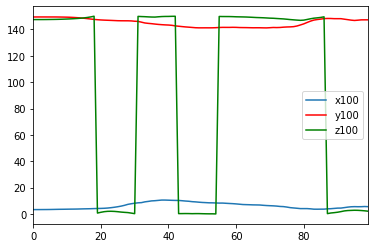

In [7]:
# Raw data
# Coordinates of atom 100 will be selected as target!
ax = plt.gca()
df.plot(kind='line', y='x100', ax=ax)
df.plot(kind='line', y='y100', color='red', ax=ax)
df.plot(kind='line', y='z100', color='green', ax=ax)

plt.show()

In [8]:
# Data generation: Increase dataset size from 1e3 to 10e4

import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors

def SMOTE(T, N, k):
  """
  Returns (N/100) * n_minority_samples synthetic minority samples.

  Parameters
  ----------
  T : array-like, shape = [n_minority_samples, n_features]
      Holds the minority samples
  N : percetange of new synthetic samples: 
      n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
  k : int. Number of nearest neighbours. 

  Returns
  -------
  S : array, shape = [(N/100) * n_minority_samples, n_features]
  """    
  n_minority_samples, n_features = T.shape

  if (N % 100) != 0:
      raise ValueError("N must be < 100 or multiple of 100")

  N = int(N/100)
  n_synthetic_samples = int(N * n_minority_samples)
  S = np.zeros(shape=(n_synthetic_samples, n_features))

  #Learn nearest neighbours
  neigh = NearestNeighbors(n_neighbors = k)
  neigh.fit(T)

  #Calculate synthetic samples
  for i in range(n_minority_samples):
      nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
      for n in range(N):
          nn_index = choice(nn[0])
          #NOTE: nn includes T[i], we don't want to select it 
          while nn_index == i:
              nn_index = choice(nn[0])

          dif = T[nn_index] - T[i]
          gap = np.random.random()
          S[n + i * N, :] = T[i,:] + gap * dif[:]

  return S

df_modified = df.iloc[:,1:] 
col = list(df_modified.columns) 
T = df_modified.to_numpy()

new_data = SMOTE(T, N = 1e4, k = 2)
new_data.shape

(10000, 1038)

In [9]:
df_new = pd.DataFrame(data = new_data,
                      index = [i for i in range(new_data.shape[0])],
                      columns = col)
df_new.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,x14,...,z333,x334,y334,z334,x335,y335,z335,x336,y336,z336,x337,y337,z337,x338,y338,z338,x339,y339,z339,x340,y340,z340,x341,y341,z341,x342,y342,z342,x343,y343,z343,x344,y344,z344,x345,y345,z345,x346,y346,z346
0,145.713,1.284673,147.596744,146.013744,0.871259,148.845744,147.267116,1.086334,149.442628,148.241372,1.755671,148.655628,147.912256,2.215564,147.348,146.626256,1.987492,146.791744,144.059,0.022209,148.310488,144.478,0.784590,147.257488,144.973628,0.115474,149.321860,143.707628,0.832597,145.988488,144.791744,149.412721,0.619062,142.919116,149.076116,148.278744,141.562116,149.501116,148.394977,143.205488,...,147.198512,61.815195,1.955983,3.203211,61.772993,0.384827,2.412642,60.283123,1.309230,2.628285,60.634353,146.909512,149.487768,62.755742,149.503676,148.701094,62.735239,147.924535,149.464789,62.890946,149.362347,0.455736,58.676079,2.367423,0.737460,57.132328,1.577107,0.628420,57.926716,2.133617,149.160488,57.317511,146.557651,148.749372,57.341349,146.429140,0.511620,58.634835,145.719768,149.557116
1,145.713,1.284647,147.596729,146.013729,0.871234,148.845729,147.267093,1.086328,149.442636,148.241364,1.755649,148.655636,147.912271,2.215515,147.348,146.626271,1.987449,146.791729,144.059,0.022169,148.310458,144.478,0.784565,147.257458,144.973636,0.115416,149.321822,143.707636,0.832577,145.988458,144.791729,149.412644,0.619009,142.919093,149.076093,148.278729,141.562093,149.501093,148.394916,143.205458,...,147.198542,61.815117,1.956049,3.203224,61.773008,0.384887,2.412659,60.283086,1.309219,2.628272,60.634330,146.909542,149.487813,62.755753,149.504134,148.701338,62.735179,147.924627,149.464240,62.890904,149.361951,0.455903,58.676024,2.367463,0.737470,57.132270,1.577170,0.628320,57.926759,2.133689,149.160458,57.317476,146.557720,148.749364,57.341313,146.429178,0.511609,58.634795,145.719813,149.557093
2,145.713,1.285382,147.597169,146.014169,0.871956,148.846169,147.267753,1.086502,149.442416,148.241584,1.756259,148.655416,147.911831,2.216919,147.348,146.625831,1.988692,146.792169,144.059,0.023333,148.311338,144.478,0.785277,147.258338,144.973416,0.117103,149.322922,143.707416,0.833166,145.989338,144.792169,149.414845,0.620546,142.919753,149.076753,148.279169,141.562753,149.501753,148.396676,143.206338,...,147.197662,61.817362,1.954135,3.202852,61.772589,0.383152,2.412157,60.284164,1.309562,2.628642,60.635012,146.908662,149.486493,62.755423,149.490931,148.694297,62.736917,147.921986,149.480083,62.892115,149.373393,0.451076,58.677608,2.366306,0.737156,57.133942,1.575352,0.631207,57.925527,2.131629,149.161338,57.318489,146.555740,148.749584,57.342347,146.428078,0.511934,58.635939,145.718493,149.557753
3,145.713,1.285584,147.597290,146.014290,0.872154,148.846290,147.267935,1.086549,149.442355,148.241645,1.756426,148.655355,147.911710,2.217304,147.348,146.625710,1.989034,146.792290,144.059,0.023653,148.311579,144.478,0.785473,147.258579,144.973355,0.117566,149.323224,143.707355,0.833328,145.989579,144.792290,149.415449,0.620968,142.919935,149.076935,148.279290,141.562935,149.501935,148.397159,143.206579,...,147.197421,61.817978,1.953610,3.202750,61.772475,0.382676,2.412020,60.284460,1.309656,2.628743,60.635199,146.908421,149.486131,62.755333,149.487308,148.692364,62.737395,147.921262,149.484431,62.892447,149.376533,0.449751,58.678043,2.365988,0.737069,57.134401,1.574853,0.631999,57.925189,2.131064,149.161579,57.318766,146.555196,148.749645,57.342631,146.427776,0.512023,58.636253,145.718131,149.557935
4,145.713,1.286661,147.597935,146.014935,0.873212,148.846935,147.268902,1.086804,149.442033,148.241967,1.757320,148.655033,147.911065,2.219362,147.348,146.625065,1.990856,146.792935,144.059,0.025360,148.312870,144.478,0.786517,147.259870,144.973033,0.120038,149.324837,143.707033,0.834193,145.990870,144.792935,149.418674,0.623222,142.920902,149.077902,148.279935,141.563902,149.502902,148.399740,143.207870,..

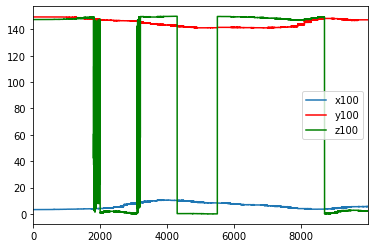

In [10]:
# After increasing dataset
ax = plt.gca()
df_new.plot(kind='line', y='x100', ax=ax)
df_new.plot(kind='line', y='y100', color='red', ax=ax)
df_new.plot(kind='line', y='z100', color='green', ax=ax)

plt.show()

In [11]:
# Other transformers also can be used!
transformer = Normalizer().fit(df_new)
# Normalize all values between 0 and 0.5 as NN works better w/ them!
array_norm = transformer.transform(df_new)*10
df_norm = pd.DataFrame(data = array_norm,
                      index = [i for i in range(new_data.shape[0])],
                      columns = col)

# Add timeStep column back
df_norm.insert(0, "TimeStep", range(1,len(df_norm)+1))
#df_norm.to_csv("normal_input_trj.csv")
df_norm.head()

,TimeStep,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,...,z333,x334,y334,z334,x335,y335,z335,x336,y336,z336,x337,y337,z337,x338,y338,z338,x339,y339,z339,x340,y340,z340,x341,y341,z341,x342,y342,z342,x343,y343,z343,x344,y344,z344,x345,y345,z345,x346,y346,z346
0,1,0.444701,0.003921,0.450450,0.445619,0.002659,0.454262,0.449444,0.003315,0.456083,0.452417,0.005358,0.453682,0.451413,0.006762,0.449691,0.447488,0.006066,0.447993,0.439653,0.000068,0.452628,0.440932,0.002394,0.449415,0.442445,0.000352,0.455715,0.438581,0.002541,0.445542,0.441889,0.455992,0.001889,0.436174,0.454965,0.452531,0.432033,0.456262,0.452886,...,0.449235,0.188654,0.005969,0.009776,0.188525,0.001174,0.007363,0.183978,0.003996,0.008021,0.185050,0.448353,0.456221,0.191524,0.456270,0.453820,0.191461,0.451450,0.456151,0.191937,0.455838,0.001391,0.179073,0.007225,0.002251,0.174362,0.004813,0.001918,0.176786,0.006512,0.455222,0.174927,0.447279,0.453968,0.175000,0.446887,0.001561,0.178947,0.444722,0.456433
1,2,0.444701,0.003921,0.450450,0.445619,0.002659,0.454262,0.449444,0.003315,0.456084,0.452417,0.005358,0.453682,0.451413,0.006762,0.449691,0.447488,0.006065,0.447993,0.439653,0.000068,0.452628,0.440932,0.002394,0.449415,0.442445,0.000352,0.455715,0.438581,0.002541,0.445542,0.441889,0.455992,0.001889,0.436174,0.454965,0.452531,0.432033,0.456262,0.452886,...,0.449235,0.188653,0.005970,0.009776,0.188525,0.001175,0.007363,0.183978,0.003996,0.008021,0.185050,0.448353,0.456221,0.191524,0.456271,0.453821,0.191461,0.451451,0.456149,0.191937,0.455837,0.001391,0.179073,0.007225,0.002251,0.174362,0.004813,0.001918,0.176786,0.006512,0.455222,0.174927,0.447279,0.453968,0.175000,0.446887,0.001561,0.178947,0.444722,0.456433
2,3,0.444701,0.003923,0.450451,0.445620,0.002661,0.454263,0.449446,0.003316,0.456083,0.452418,0.005360,0.453681,0.451411,0.006766,0.449691,0.447487,0.006069,0.447994,0.439653,0.000071,0.452631,0.440932,0.002397,0.449417,0.442444,0.000357,0.455718,0.438580,0.002543,0.445544,0.441891,0.455999,0.001894,0.436176,0.454967,0.452533,0.432035,0.456264,0.452891,...,0.449232,0.188660,0.005964,0.009775,0.188523,0.001169,0.007362,0.183981,0.003997,0.008022,0.185052,0.448350,0.456217,0.191523,0.456231,0.453799,0.191467,0.451442,0.456198,0.191940,0.455872,0.001377,0.179078,0.007222,0.002250,0.174367,0.004808,0.001926,0.176783,0.006506,0.455225,0.174930,0.447273,0.453968,0.175003,0.446883,0.001562,0.178951,0.444718,0.456435
3,4,0.444701,0.003923,0.450451,0.445620,0.002662,0.454263,0.449446,0.003316,0.456082,0.452418,0.005360,0.453681,0.451411,0.006767,0.449691,0.447486,0.006070,0.447995,0.439653,0.000072,0.452631,0.440932,0.002397,0.449418,0.442443,0.000359,0.455719,0.438580,0.002543,0.445545,0.441891,0.456000,0.001895,0.436177,0.454967,0.452533,0.432035,0.456264,0.452893,...,0.449231,0.188662,0.005962,0.009774,0.188523,0.001168,0.007361,0.183982,0.003997,0.008023,0.185052,0.448349,0.456216,0.191523,0.456220,0.453794,0.191468,0.451440,0.456211,0.191941,0.455882,0.001373,0.179079,0.007221,0.002249,0.174368,0.004806,0.001929,0.176782,0.006504,0.455226,0.174931,0.447271,0.453968,0.175004,0.446882,0.001563,0.178952,0.444716,0.456435
4,5,0.444701,0.003927,0.450453,0.445622,0.002665,0.454265,0.449449,0.003317,0.456081,0.452419,0.005363,0.453679,0.451409,0.006773,0.449690,0.447484,0.006076,0.447996,0.439653,0.000077,0.452635,0.440931,0.002400,0.449421,0.442442,0.000366,0.455723,0.438579,0.002546,0.445549,0.441893,0.456010,0.001902,0.436179,0.454970,0.452535,0.432038,0.456267,0.452900,...,0.449227,0.188672,0.005954,0.009773,0.188521,0.001160,0.007359,0.183987,0.003998,0.008024,0.185055,0.448345,0.456210,0.191521,0.456160,0.453762,0.191476,0.451428,0.456281,0.191946,0.455932,0.001351,0.179086,0.007216,0.002248,0.174376,0.004798,0.001942,0.176776,0.006495,0.455229,0.174935,0.447262,0.453969,0.175008,0.446877,0.001564,0.178957,0.444710,0.456438


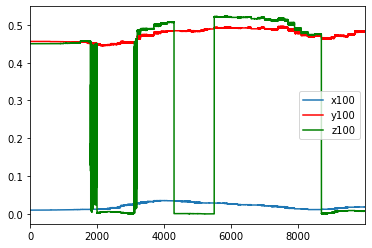

In [12]:
ax = plt.gca()
df_norm.plot(kind='line', y='x100', ax=ax)
df_norm.plot(kind='line', y='y100', color='red', ax=ax)
df_norm.plot(kind='line', y='z100', color='green', ax=ax)

plt.show()

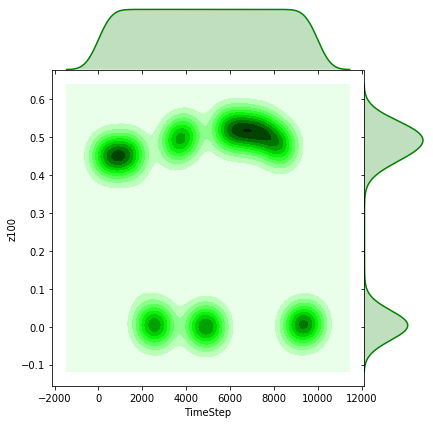

In [13]:
sns.jointplot("TimeStep", "z100", df_norm, kind="kde", space=0, color="g")

In [14]:
target = ['x100', 'y100', 'z100'] # Atom 100
shift_steps = 400      # Lag
df_targets = df_norm[target].shift(-shift_steps)
n1 = df_norm.columns.get_loc("x100")

# Use 10 neighbour atoms (33 col in total) as the feature vectors
feature_col = df_norm.columns[n1-15:n1+18]
df_feature = df_norm[feature_col]

x_data = df_feature.values[0:-shift_steps]
y_data = df_targets.values[0:-shift_steps]  

num_data = len(x_data)  
train_split = 0.85       # fraction of the dataset for the training

num_train = int(train_split * num_data)
num_test = num_data - num_train

x_train = x_data[0:num_train]
x_test = x_data[num_train:]

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

validation_data = (np.expand_dims(x_test, axis=0),
                   np.expand_dims(y_test, axis=0))

print("num_x_signals: ", num_x_signals)

num_x_signals:  33


In [15]:
# Batch generator
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training data.
    """
    batch_num = int(num_train/batch_size) + 1
    # Infinite loop
    while True:
        # Allocate a new array for the batch of inputs.
        x_shape = (batch_num, batch_size, num_x_signals)
        x_batch = np.zeros(shape = x_shape, dtype = np.float64)
        print(x_shape)
        # Allocate a new array for the batch of outputs.
        y_shape = (batch_num, batch_size, num_y_signals)
        y_batch = np.zeros(shape = y_shape, dtype = np.float64)

        # Fill the batch with random sequences of data.
        for i in range(batch_num):
            # Get a random start-index.
            # This points somewhere into the training data.
            idx = np.random.randint(num_train - batch_size)
            idx = np.random.randint(num_train - batch_size)
            
            x_batch[i] = x_train[idx:idx+batch_size]
            y_batch[i] = y_train[idx:idx+batch_size]
          
        yield (x_batch, y_batch)

batch_size = 128  # 2^n like!
generator = batch_generator(batch_size = batch_size)
x_batch, y_batch = next(generator)

(67, 128, 33)


In [16]:
# Create the Recurrent Neural Network
model = Sequential()
model.add(GRU(units = 256,   
              return_sequences = True,
              input_shape = (None, num_x_signals,)))

# To predict 3 output signals, we add a dense layer,
# which maps output values down to only 3 values.
model.add(Dense(num_y_signals, activation = 'sigmoid'))

if False:
    from tensorflow.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.02, maxval=0.02)  
    model.add(Dense(num_y_signals,
                    activation = 'linear',
                    kernel_initializer = init))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Loss Function: MSE
warmup_steps = 500   

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are: [batch_num, batch_size, num_x_signals]
    # Ignore the "warmup" parts of the sequences

    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # Calculate the MSE loss for each value in these tensors.
    # Be aware of upgraded version of TensorFlow in colab!
    loss = tf.compat.v1.losses.mean_squared_error(y_true_slice, y_pred_slice)
    loss_mean = tf.reduce_mean(input_tensor = loss)

    return loss_mean

In [18]:
# Compile Model
optimizer = RMSprop(lr = 1e-3)   
model.compile(loss = loss_mse_warmup, optimizer = optimizer, metrics = ['accuracy'])
model.summary()

# Callback Functions
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath = path_checkpoint,
                                      monitor = 'val_loss',
                                      verbose = 1,
                                      save_weights_only = True,
                                      save_best_only = True)

callback_early_stopping = EarlyStopping(monitor = 'val_loss',
                                        patience = 8, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq = 0,   
                                   write_graph = False)  
# Min learning rate 1e-5
callback_reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                       factor = 0.10,    
                                       min_lr = 1e-5,   
                                       patience = 2,
                                       verbose = 1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 256)         222720    
_________________________________________________________________
dense (Dense)                (None, None, 3)           771       
Total params: 223,491
Trainable params: 223,491
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train the Recurrent Neural Network
model.fit_generator(generator = generator,
                    epochs = 30,             # least 20 - keep it higher just for safty!
                    steps_per_epoch = int(num_train/batch_size),   # batch_size would be a good bet
                    validation_data = validation_data,
                    callbacks = callbacks)

# Load Checkpoint
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

print("batch_size = ", batch_size)

(67, 128, 33)
(67, 128, 33)
(67, 128, 33)
(67, 128, 33)
(67, 128, 33)
(67, 128, 33)
(67, 128, 33)
(67, 128, 33)
(67, 128, 33)
(67, 128, 33)
(67, 128, 33)
Epoch 1/30
(67, 128, 33)
65/66 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.5225(67, 128, 33)
Epoch 1/30
 1/66 [..............................] - ETA: 46s - loss: 0.0068 - acc: 0.8707
Epoch 00001: val_loss improved from inf to 0.00676, saving model to 23_checkpoint.keras
66/66 [==============================] - 18s 280ms/step - loss: 0.0122 - acc: 0.5227 - val_loss: 0.0068 - val_acc: 0.8707
Epoch 2/30
(67, 128, 33)
65/66 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.6428(67, 128, 33)
Epoch 1/30
 1/66 [..............................] - ETA: 43s - loss: 0.0266 - acc: 0.9632
Epoch 00002: val_loss did not improve from 0.00676
66/66 [==============================] - 16s 241ms/step - loss: 0.0039 - acc: 0.6405 - val_loss: 0.0266 - val_acc: 0.9632
Epoch 3/30
(67, 128, 33)
65/66 [===================

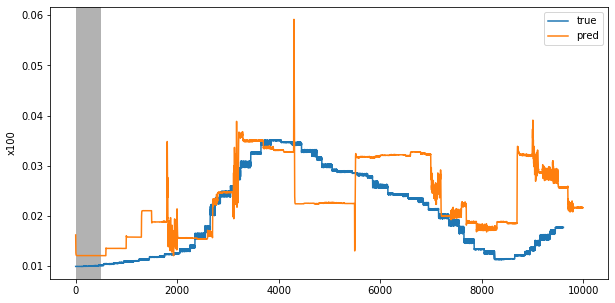

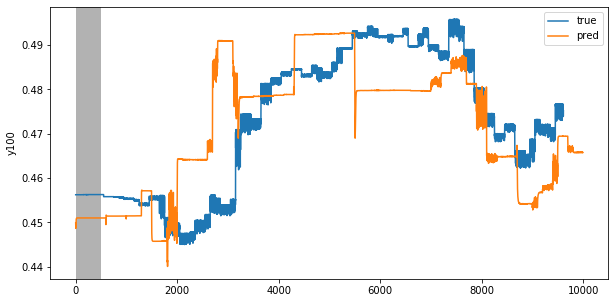

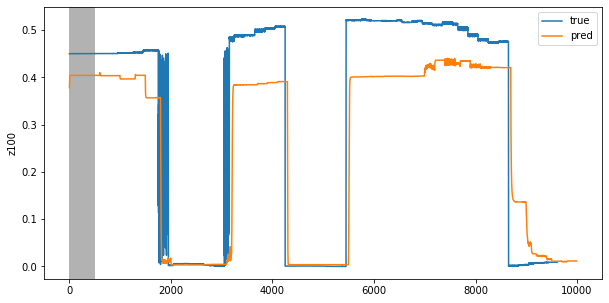

In [46]:
# Generate Predictions
def plot_comparison(start_idx, length):
    """
    Plot the predicted and true output-signals.
    
    :par start_idx: Start-index for the time-series.
    :par length: Sequence length to process and plot.
    """
    # Entire dataset
    x = df_feature.values[:]
    y_true = df_targets.values[:]
    
    end_idx = start_idx + length
    # Pridict the future: the same amount as "shift" value!
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input signals for the model.
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)    # GRU model

    # print(y_pred[0].shape)
    # print(y_true.shape)

    for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred[0][:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(10,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.3)
        
        # Plot labels
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()

# Plot
plot_comparison(start_idx = 0, length = 10000)
